# Demonstration of DCBC evaluation usage (Replication)
This notebook shows an example of a Distance controlled boundary coefficient (DCBC) evaluation of a cortical parcellation using the Multi-domain task battery (MDTB) functional dataset. It replicates the results reported in the article

- Zhi, D., King, M., Hernandez‐Castillo, C. R., & Diedrichsen, J. (2022). Evaluating brain parcellations using the distance‐controlled boundary coefficient. Human Brain Mapping, 43(12), 3706-3720.

## Installation and Dependencies

Ensure Python version >= 3.6 and pip installable on your system.

`pip install nibabel scipy numpy sklearn matplotlib`

## Required files for DCBC computation

- `parcels`: is a N-long vector brain parcellation, wheere N is the number of surface vertices
- `dist_file`: is the file path of the precomputed distance matrix. It is a `.mat` format file stores a `N x N` pairwise distance matrix between all vertices with a field name `avrgDs`. To successfully run this example, user must have a distance file in the `distanceMatrix` folder. Due to GitHub upload limit, we provide several pre-computed distance matrix file at https://www.diedrichsenlab.org/toolboxes/toolbox_dcbc.htm
- `test data`: in this example, the parcellation will be evaluated on `MDTB` dataset. We provide the task beta weights in `data` folder. Please find step-by-step 1 below this example. 

## Usage
This is a quick sample of calculating the DCBC metric for evaluating `Power 2011` left hemisphere on the `MDTB` task-evoked dataset.

In [1]:
from examples.replication import DCBC
from utilities import plot_wb_curve
import nibabel as nb
import numpy as np

In [2]:
print('Start evaluating DCBC sample code ...')

# Load cortical parcellation from label.gii file
gii_file = nb.load('../parcellations/Power2011.32k.L.label.gii')
# Extract the first data array as the parcels  
# Make sure the input parcels has a shape of (N,)
parcels = gii_file.darrays[0].data 

# Create a DCBC evaluation object of the desired evaluation parameters(left hemisphere)
myDCBC = DCBC(hems='L', maxDist=35, binWidth=1, dist_file="../distanceMatrix/distAvrg_sp.mat")

# Do the valuation on the parcellation 
T = myDCBC.evaluate(parcels)

Start evaluating DCBC sample code ...
Evaluating L hemisphere for subject s02
Evaluating L hemisphere for subject s03
Evaluating L hemisphere for subject s04
Evaluating L hemisphere for subject s06
Evaluating L hemisphere for subject s08
Evaluating L hemisphere for subject s09
Evaluating L hemisphere for subject s10
Evaluating L hemisphere for subject s12
Evaluating L hemisphere for subject s14
Evaluating L hemisphere for subject s15
Evaluating L hemisphere for subject s17
Evaluating L hemisphere for subject s18
Evaluating L hemisphere for subject s19
Evaluating L hemisphere for subject s20
Evaluating L hemisphere for subject s21
Evaluating L hemisphere for subject s22
Evaluating L hemisphere for subject s24
Evaluating L hemisphere for subject s25
Evaluating L hemisphere for subject s26
Evaluating L hemisphere for subject s27
Evaluating L hemisphere for subject s28
Evaluating L hemisphere for subject s29
Evaluating L hemisphere for subject s30
Evaluating L hemisphere for subject s31


evaluating s09 L ...


evaluating s10 L ...


evaluating s12 L ...


evaluating s14 L ...


evaluating s15 L ...


evaluating s17 L ...


evaluating s18 L ...


evaluating s19 L ...


evaluating s20 L ...


evaluating s21 L ...


evaluating s22 L ...


evaluating s24 L ...


evaluating s25 L ...


evaluating s26 L ...


evaluating s27 L ...


evaluating s28 L ...


evaluating s29 L ...


evaluating s30 L ...


evaluating s31 L ...


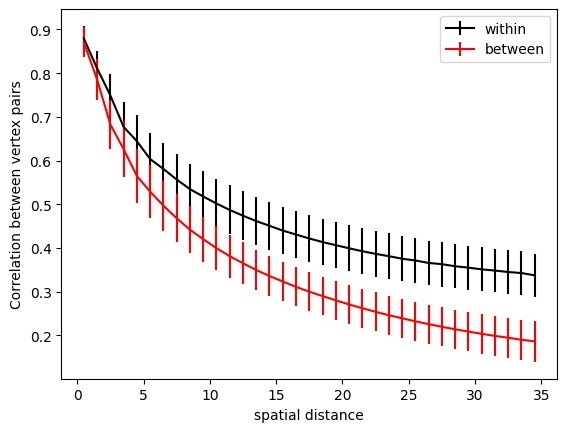

DCBC values for MDTB 24 subjects are: [0.14172631 0.1359262  0.10317946 0.20197995 0.06820656 0.11891234
 0.15825186 0.17356879 0.09266759 0.16872749 0.20323118 0.12162858
 0.14541997 0.11714071 0.10080841 0.19394683 0.0943143  0.11375709
 0.15701022 0.09394004 0.18074916 0.10213594 0.0617984  0.11139157]


In [3]:
# Plotting the within/between curve
%matplotlib inline
plot_wb_curve(T, path='../data', hems='L')
dcbc_values = np.stack([t['DCBC'] for t in T.values()])
print(f'DCBC values for MDTB 24 subjects are: {dcbc_values}')

## Step by step explanation for DCBC calculation

**1. Choose an appropriate data set**

To what goal we want to achieve, the underlying dataset can be varying in terms of the type (for example, we can carry out to use functional resting-state connectivity pattern if we want to know how good the given parcellation in predicting functional resting-state boundaries, see paper for more details). We start here of choosing an appropriate dataset.

The public `evaluate` function of class `DCBC` will iteratively scan all subject data `sXX` in the `data` folder. Structure as below.
```
DCBC/
 └───data/
        s02/
	 |   s02.L.wbeta.32k.func.gii
	 |   s02.R.wbeta.32k.func.gii
	...
	s31/
	 |   s31.L.wbeta.32k.func.gii
	 |   s31.R.wbeta.32k.func.gii

```

There are two connectivity profile in each of the subject folder `sXX` for left and right hemisphere, respectively. User can copy your own subject data into 'data' folder and make sure it follows the above structure. 

In each `func.gii` file per subject, it stores a `num_task x N` betas matrix, where `num_task=34` indicates the total 34 tasks and `N=32492` is the number of cortical vertices per hemisphere.

**2. Define and calculate distance metrics**

The class `DCBC` will pass in `dist_file` to refer the distance metric file between all vertex/voxel pairs. We provide some pre-computed distance metrics at <a href="http://www.diedrichsenlab.org/" target="_blank">here</a>. In this notebook, we used `distAvrg_sp.mat` as an example, which is the shortest paths between each pair of vertices using Dijkstra's algorithm.

Or you can use helper function `compute_distance` to compute your own distance. Note, if you to do so, please store the result distance matrix in `.mat` file with a field name `avrgDs`. For instance, the below code segmentation calculates the euclidean distance for each vertex pairs of HCP standard mesh of left hemisphere.

In [4]:
from utilities import compute_dist_from_surface
import scipy.io as spio

dist = compute_dist_from_surface(files='../parcellations/fs_LR_32k template/fs_LR.32k.L.sphere.surf.gii',
                                 type='euclidean', max_dist=50, sparse=False)
print(dist.shape)
spio.savemat('../distanceMatrix/distEucl_sp.mat', {'avrgDs': dist})

(32492, 32492)


there are also few options to controll the ouput distance file. 

- `files`: the surface gifti file to compute the pairwise distance.
- `sparse`: If `sparse=True` the output distance file will be converted to sparse matrix. It would be beneficial for the very large distance matrix.
- `max_dist` controlls the maximum distance between the vertex pairs to calculation. The distance of a vertex pair will be set to 0 if it's greater than the maximum distance. Default `max_dist=50`.
- `type` indicates which distance kernel will be applied. Default is `euclidean` distance.

**3. Get the parcellation**

We organized and provide several state-of-the-art or commonly used cortical parcellations in HCP standard fs-LR 32k template in `parcellations` folder. For the current version of DCBC project, we only support this template, the nifti file will be included soon in the updates. User can also copy own parcellation files to this folder.

In [5]:
# Load cortical parcellation from label.gii file
#  Extract the first data array as the parcels, make sure the input parcels has a shape of (N,)
gii_file = nb.load('../parcellations/Power2011.32k.L.label.gii')
parcels = gii_file.darrays[0].data
print(parcels.shape)

(32492,)


**4. Define and compute similarity measures**

In each iteration of the subject evaluation, DCBC computes the similarity matrix between each vertex for further comparison. User can also use helper function `compute_similarity` to calculate other similarity matrix. For example below:

In [6]:
from utilities import compute_similarity

similarity = compute_similarity(files='../data/s02/s02.L.wbeta.32k.func.gii', type='pearson', sparse=False, mean_centering=True)
print(similarity.shape)

(32492, 32492)


This example shows how to generate pearson's correlation for the functional connectiviy of subject 02's left hemisphere. Variable `type` controls the similarity kernel, e.g `cosine`, `pearson`. If `sparse=True`, then the output will be a sparse matrix. If `mean_centering=True` then the subject's connectivity pattern will be mean centered before doing the calculation.

**5. Bin and integrate across bins**

The parameter `binWidth` is essential to get a good evaluation result as we described in the paper. Default bin width was set to 1 mm as it is a good compromise between bias, variances, and computational cost. But this can be changed based on your distance file or others. Here we show an example of passing 2.5 mm bin width as a comparison to the 1 mm result.

In [ ]:
# Create a DCBC evaluation object of the desired evaluation parameters(left hemisphere)
myDCBC = DCBC(hems='L', maxDist=35, binWidth=2.5, dist_file="../distanceMatrix/distAvrg_sp.mat")

# Do the valuation on the parcellation 
T = myDCBC.evaluate(parcels)

**6. Plotting results**

The helper function file `plotting.py` contains the plotting function `plot_wb_curve` to decode the result from previous steps. The output figure will be within- and between parcel correlation curve. A larger difference between the two curve indicates the given parcellation has better performance in predicting the underlying type data boundaires. Below is the example within- and between- curve for the left hemisphere of `Power 2011` parcellation. 

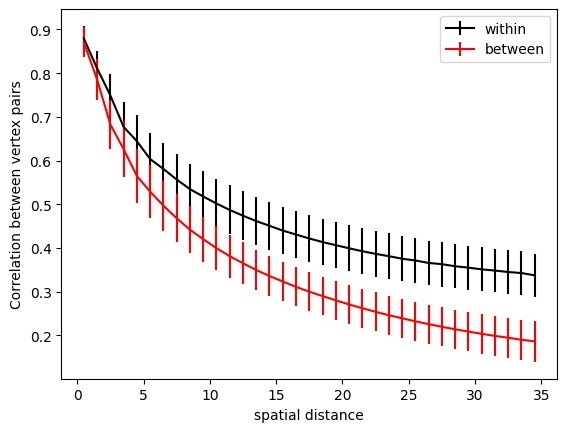

In [7]:
# Plotting the within/between curve
%matplotlib inline
plot_wb_curve(T, path='../data', hems='L')

Finally, from the above result observation, we can compare the quality of different parcellations. If you want to get the real value of the curve at each bin, you can access to the returned dictionary structure.